In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/jolivie1/Desktop/Research/equivalence_testing/scripts/')

from equiv_test_funcs_vectorized import *

In [2]:
def write_sim_files(num, delta, datapath, metapath, geneA_fracs, num_samples):
    data = {"sample" : [], "A" : [], "B" : [], "condition" : []}
    count = 0
    for j in range(len(geneA_fracs)):
        for k in range(num_samples):
            count += 1
            n = np.random.poisson(num)
            A = np.random.binomial(n, geneA_fracs[j])
            data["sample"].append("sample" + str(count))
            data["A"].append(A)
            data["B"].append(n - A)
            data["condition"].append(j)
    df = pd.DataFrame(data).set_index("sample")
    meta = df[["condition"]]  
    data = df[[x for x in df.columns if x != "condition"]].T

    #display(data)
    data.to_csv(datapath)
    meta.to_csv(metapath)

def get_significance():
    calc_df = perform_full_analysis(datapath, metapath, "condition", delta)
    
    if "A" in calc_df.index:
        return calc_df.loc["A"]["sig_diff"], calc_df.loc["A"]["sig_equiv"]
    return False, False

def run_simulation(numReads, num_trials, delta, datapath, metapath, geneA_fracs, num_samples):
    out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
           "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
           "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

    for num in numReads:
        print("num reads: {}".format(num))
        # collect p vals for each
        num_sig_diff = 0
        num_sig_equiv = 0
        num_inconclusive = 0

        for i in range(num_trials):

            # simulate data
            write_sim_files(num, delta, datapath, metapath, geneA_fracs, num_samples)

            # get results
            diff_sig, equiv_sig = get_significance()

            # save output
            num_sig_diff += diff_sig
            num_sig_equiv += equiv_sig
            num_inconclusive += 1 - diff_sig - equiv_sig

        # get frac significant
        out["numReads"].append(num)

    #    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
        out["frac_sig_diff"].append(num_sig_diff/num_trials)
        out["frac_sig_diff_lower"].append(lower_ci)
        out["frac_sig_diff_upper"].append(upper_ci)

    #    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
        out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
        out["frac_sig_equiv_lower"].append(lower_ci)
        out["frac_sig_equiv_upper"].append(upper_ci)


    #    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
        lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
        out["frac_sig_inc"].append(num_inconclusive/num_trials)
        out["frac_sig_inc_lower"].append(lower_ci)
        out["frac_sig_inc_upper"].append(upper_ci)

    out = pd.DataFrame(out)
    return out

In [17]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [91]:
num_points = 21

frac_As = np.linspace(0, 1, num_points)
#frac_As = np.linspace(0, 1, 5)
print(frac_As)

numReads = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 1000, 10000]
#numReads = [1, 2, 3, 4, 5, 10, 20]

num_trials = 10
num_samples = 3
delta = 1
outpath = "/Users/jolivie1/Desktop/Research/equivalence_testing_output/notebooks/output/simulation_grid_vectorize/"
datapath = "{}data.csv".format(outpath)
metapath = "{}meta.csv".format(outpath)

results_dict = {"fracA1" : [], "fracA2" : [], "end_state" : [], "numReads_end" : []}

for n in numReads:
    results_dict["{} result".format(n)] = []

for A1 in frac_As:
    print("########################################################################")
    print("##########################        {}        ##########################".format(A1))
    print("########################################################################")
    for A2 in frac_As:
        out = run_simulation(numReads, num_trials, delta, datapath, metapath, [A1, A2], num_samples)
        
        # create column with max of each row
        out["max_col"] = out[["frac_sig_diff", "frac_sig_equiv", "frac_sig_inc"]].idxmax(axis=1).map({
                    "frac_sig_inc" : "inconclusive", 
                    "frac_sig_equiv" : "equivalent", 
                    "frac_sig_diff" : "different"})
        
        end_state = out.iloc[-1]["max_col"]

        for i in range(out.shape[0] - 1, -1, -1):
            if out.loc[i,"max_col"] != end_state:
                break
                
        results_dict["fracA1"].append(A1)
        results_dict["fracA2"].append(A2)
        results_dict["end_state"].append(end_state)
        results_dict["numReads_end"].append(out.loc[i +1, "numReads"])
        
        for index, row in out.iterrows():
            results_dict["{} result".format(row["numReads"])].append(row["max_col"])

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
########################################################################
##########################        0.0        ##########################
########################################################################
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num 

num reads: 1000
num reads: 10000
########################################################################
##########################        0.1        ##########################
########################################################################
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num 

num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num r

num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 1

num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num

num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100


num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads:

num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num re

num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 1

num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num

num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
num reads: 100
num reads: 1000
num reads: 10000
num reads: 1
num reads: 2
num reads: 3
num reads: 4
num reads: 5
num reads: 10
num reads: 20
num reads: 30
num reads: 40
num reads: 50
nu

In [92]:
results = pd.DataFrame(results_dict).sort_values("numReads_end")
results["read number"] = results["numReads_end"].astype(str)
results

,fracA1,fracA2,end_state,numReads_end,1 result,2 result,3 result,4 result,5 result,10 result,20 result,30 result,40 result,50 result,100 result,1000 result,10000 result,read number
0,0.00,0.00,inconclusive,2,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,2
422,1.00,0.10,different,3,inconclusive,inconclusive,different,different,different,different,different,different,different,different,different,different,different,3
37,0.05,0.80,different,3,inconclusive,inconclusive,different,different,different,different,different,different,different,different,different,different,different,3
20,0.00,1.00,different,3,inconclusive,inconclusive,different,different,different,different,different,different,different,different,different,different,different,3
19,0.00,0.95,different,3,inconclusive,inconclusive,different,different,different,different,different,different,different,different,different,different,different,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.40,0.20,inconclusive,10000,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,different,inconclusive,10000
46,0.10,0.20,inconclusive,10000,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,different,inconclusive,10000
229,0.50,0.95,equivalent,10000,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,equivalent,10000
160,0.35,0.65,equivalent,10000,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,inconclusive,equivalent,10000


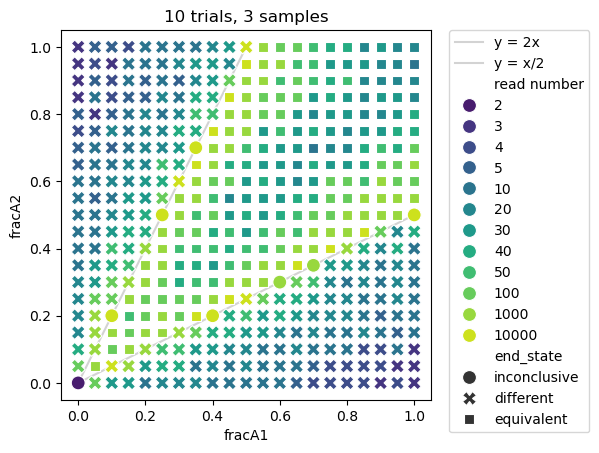

In [93]:

fig, ax = plt.subplots()

ax.set_aspect('equal', adjustable='box')
plt.title("{} trials, {} samples".format(num_trials, num_samples))

# Add the lines y = 2x and y = x/2 to the plot
ax.plot([0, 0.5], [0, 1], color='lightgray', linestyle='-', label='y = 2x', zorder=1)

ax.plot([0, 1], [0, 0.5], color='lightgray', linestyle='-', label='y = x/2', zorder=1)

g = sns.scatterplot(data = results, x = "fracA1", y = "fracA2", style="end_state", 
                hue = "read number", palette="viridis", 
                s=100,ax=ax)
               #sizes=(100, 200),ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("{}{}_{}_grid.png".format(outpath, num_trials, num_points),bbox_inches="tight",dpi=300)

plt.show()

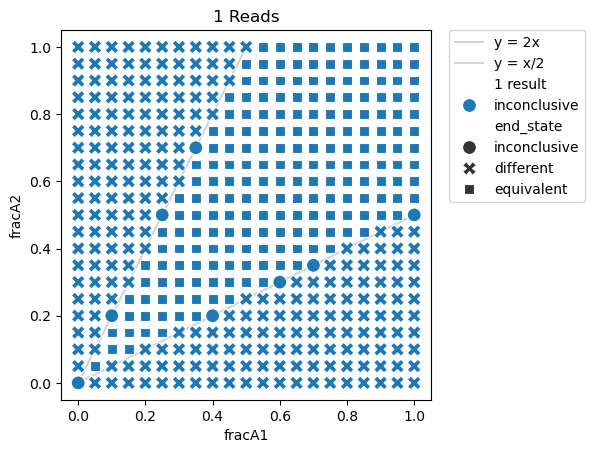

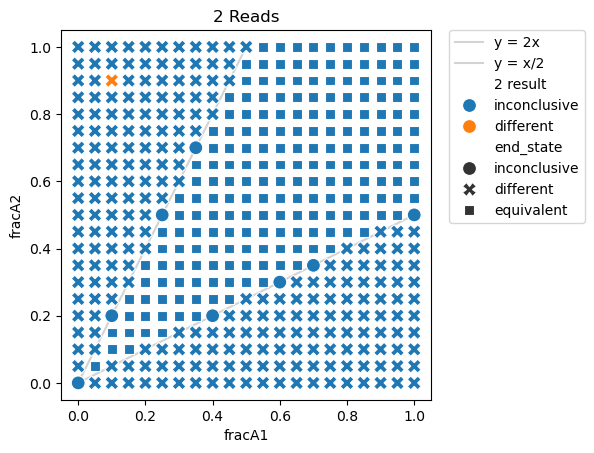

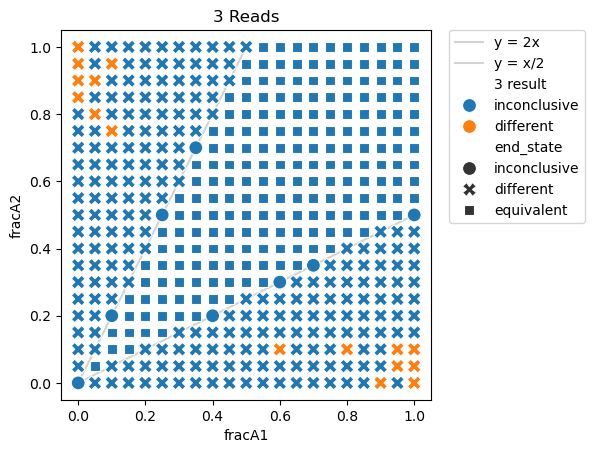

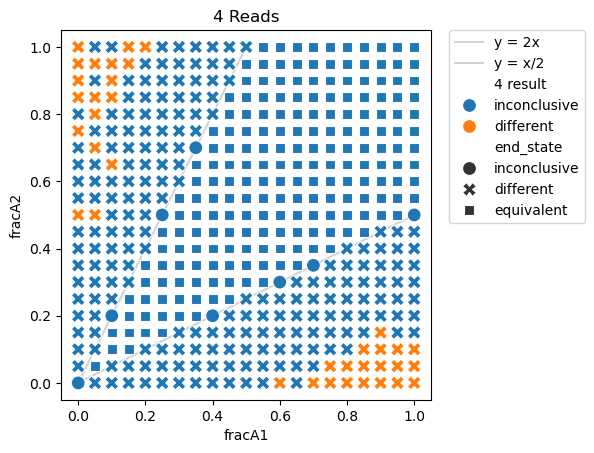

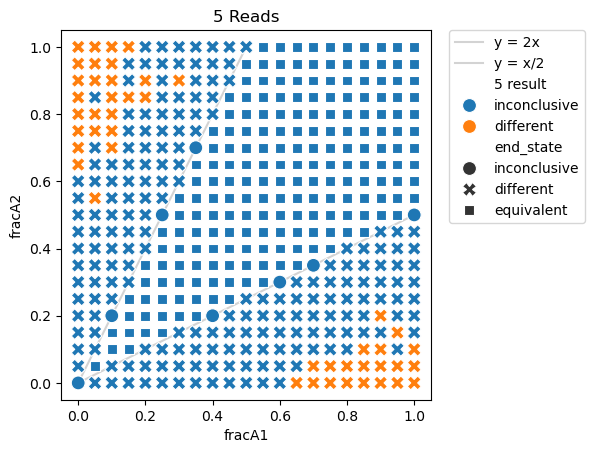

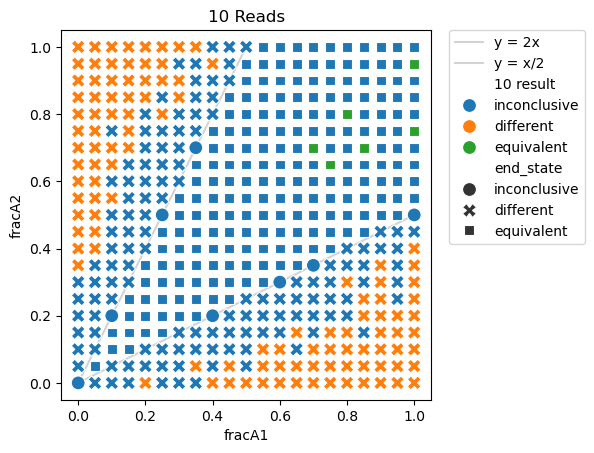

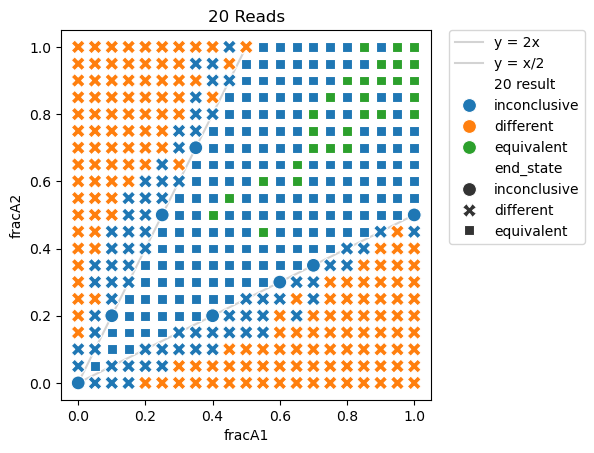

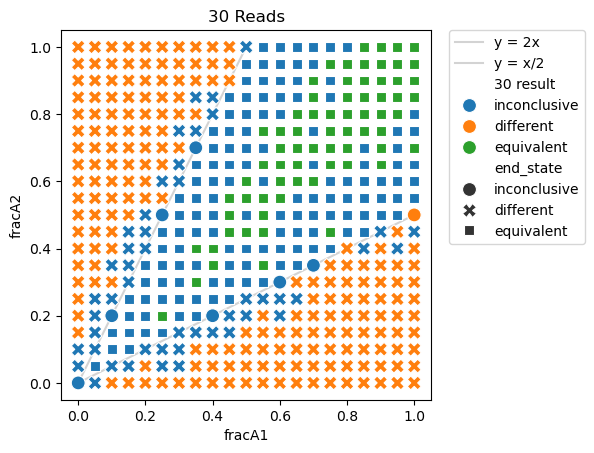

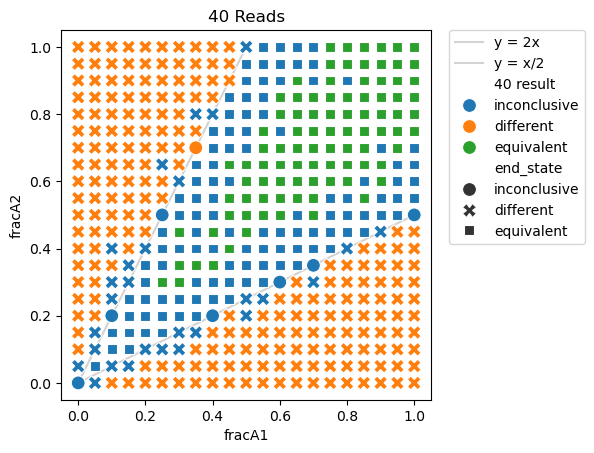

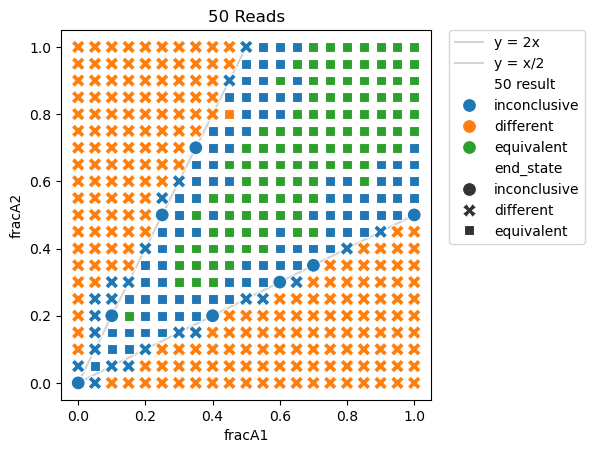

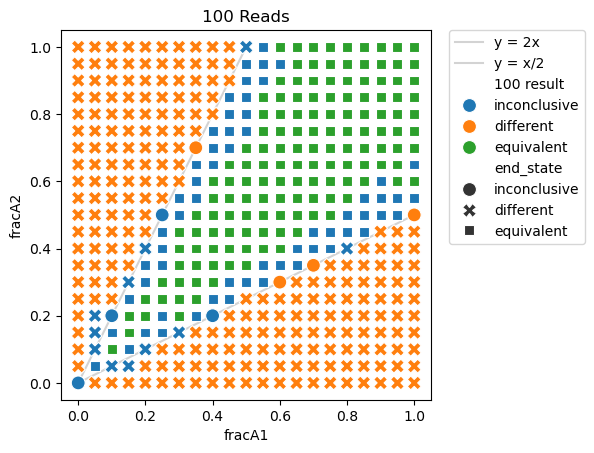

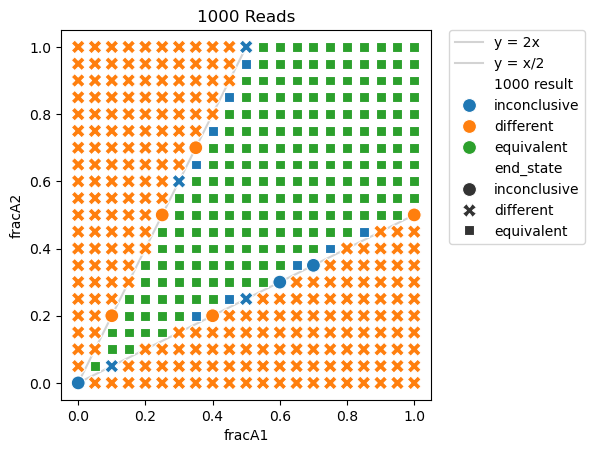

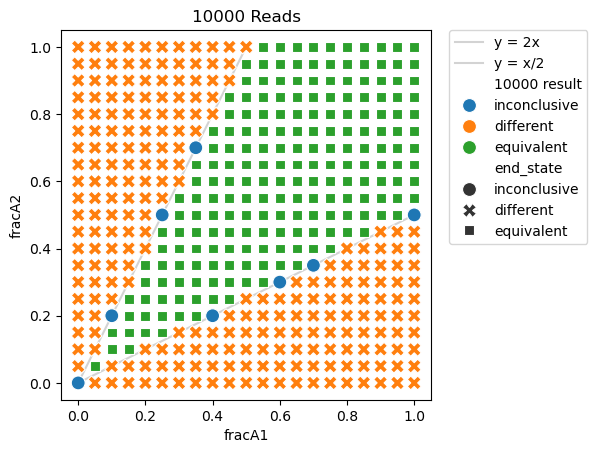

In [94]:
for n in numReads:
    fig, ax = plt.subplots()
    plt.title("{} Reads".format(n))

    ax.set_aspect('equal', adjustable='box')

    # Add the lines y = 2x and y = x/2 to the plot
    ax.plot([0, 0.5], [0, 1], color='lightgray', linestyle='-', label='y = 2x', zorder=1)

    ax.plot([0, 1], [0, 0.5], color='lightgray', linestyle='-', label='y = x/2', zorder=1)

    g = sns.scatterplot(data = results, x = "fracA1", y = "fracA2", style="end_state", 
                    hue = "{} result".format(n),  
                   s=100,ax=ax)

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.savefig("{}{}_{}_{}reads.png".format(outpath,num_trials, num_points,n),bbox_inches="tight",dpi=300)
    plt.show()